<a href="https://colab.research.google.com/github/wesleybeckner/data_science_foundations/blob/main/notebooks/S6_Bagging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Foundations, Session 6: Bagging: Decision Trees and Random Forests

**Instructor**: Wesley Beckner

**Contact**: wesleybeckner@gmail.com

---

<br>

In this session, we're going back to the topic of supervised learning models. These models however, belong to a special class of methods called bagging, or bootstrap aggregation. 

Bagging is an ensemble learning method. In this method, many weak classifiers cast their votes in a general election for the final prediction. 

The weak learners that random forests are made of, are called decision trees. 
<p align="center">
<img src="https://media.giphy.com/media/uX5BYSQALx12o/giphy.gif" width=400px></img>
</p>

<br>

---

<a name='top'></a>

<a name='x.0'></a>

## 6.0 Preparing Environment and Importing Data

[back to top](#top)

<a name='x.0.1'></a>

### 6.0.1 Import Packages

[back to top](#top)

In [32]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import plotly.express as px
import random
import scipy.stats
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns; sns.set()
import graphviz 
from sklearn.metrics import accuracy_score
from ipywidgets import interact, interactive, widgets
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import metrics

<a name='x.0.2'></a>

### 6.0.2 Load Dataset

[back to top](#top)

In [33]:
margin = pd.read_csv('https://raw.githubusercontent.com/wesleybeckner/'\
                 'ds_for_engineers/main/data/truffle_margin/truffle_margin_customer.csv')
print(margin.shape, end='\n\n')
display(margin.head())

(1668, 9)



,Base Cake,Truffle Type,Primary Flavor,Secondary Flavor,Color Group,Customer,Date,KG,EBITDA/KG
0,Butter,Candy Outer,Butter Pecan,Toffee,Taupe,Slugworth,1/2020,53770.342593,0.500424
1,Butter,Candy Outer,Ginger Lime,Banana,Amethyst,Slugworth,1/2020,466477.578125,0.220395
2,Butter,Candy Outer,Ginger Lime,Banana,Burgundy,Perk-a-Cola,1/2020,80801.728070,0.171014
3,Butter,Candy Outer,Ginger Lime,Banana,White,Fickelgruber,1/2020,18046.111111,0.233025
4,Butter,Candy Outer,Ginger Lime,Rum,Amethyst,Fickelgruber,1/2020,19147.454268,0.480689


We're going to recreate the same operations we employed in Session 4, Feature Engineering:

In [34]:
# identify categorical columns
cat_cols = margin.columns[:7]

# create the encoder object
enc = OneHotEncoder()

# grab the columns we want to convert from strings
X_cat = margin[cat_cols]

# fit our encoder to this data
enc.fit(X_cat)
onehotlabels = enc.transform(X_cat).toarray()
X_num = margin[['KG']]
X_truf = np.concatenate((onehotlabels, X_num.values),axis=1)

# grab our y data
y_truf = margin['EBITDA/KG'].values

Lastly, to create a classification task, we're going to identify high, med, and low value products:

bad less than: 0.12

low less than: 0.22

med less than: 0.35



<AxesSubplot:>

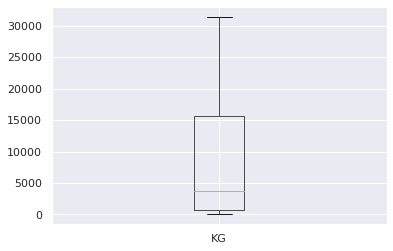

In [35]:
print('bad less than: {:.2f}'.format(margin[margin.columns[-1]].quantile(.25)), end='\n\n')
print('low less than: {:.2f}'.format(margin[margin.columns[-1]].quantile(.5)), end='\n\n')
print('med less than: {:.2f}'.format(margin[margin.columns[-1]].quantile(.75)), end='\n\n')
pd.DataFrame(margin[margin.columns[-2]]).boxplot(showfliers=False)

In [36]:
margin['profitability'] = margin[margin.columns[-1]].apply(
    lambda x: 'bad' if x <= margin[margin.columns[-1]].quantile(.25) else
              'low' if x <= margin[margin.columns[-1]].quantile(.50) else
              'med' if x <= margin[margin.columns[-1]].quantile(.75) else 'high')

<AxesSubplot:>

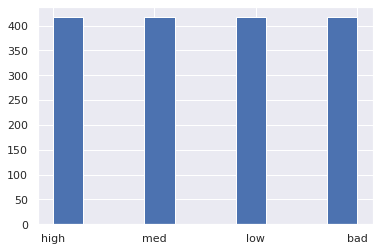

In [37]:
margin['profitability'].hist()

In [38]:
class_profit = {'bad': 0, 'low': 1, 'med': 2, 'high': 3}
y_truf_class = margin['profitability'].map(class_profit).values
margin['profitability_encoding'] = y_truf_class
margin.head()

,Base Cake,Truffle Type,Primary Flavor,Secondary Flavor,Color Group,Customer,Date,KG,EBITDA/KG,profitability,profitability_encoding
0,Butter,Candy Outer,Butter Pecan,Toffee,Taupe,Slugworth,1/2020,53770.342593,0.500424,high,3
1,Butter,Candy Outer,Ginger Lime,Banana,Amethyst,Slugworth,1/2020,466477.578125,0.220395,med,2
2,Butter,Candy Outer,Ginger Lime,Banana,Burgundy,Perk-a-Cola,1/2020,80801.728070,0.171014,low,1
3,Butter,Candy Outer,Ginger Lime,Banana,White,Fickelgruber,1/2020,18046.111111,0.233025,med,2
4,Butter,Candy Outer,Ginger Lime,Rum,Amethyst,Fickelgruber,1/2020,19147.454268,0.480689,high,3


<a name='x.1'></a>

## 6.1 Decision Trees

[back to top](#top)

In essence, a decision tree is a series of binary questions. 

<img src="https://miro.medium.com/max/499/0*KQUBhmPmWeP8mHQz.jpeg" width=400px></img>

Let's begin this discussion by talking about how we make decision trees in sklearn.

<a name='x.1.1'></a>

### 6.1.1 Creating a Decision Tree

[back to top](#top)

In [39]:
from sklearn import tree
X = [[0, 0], [1, 1]]
y = [0, 1]
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

After fitting the model we can use the predict method to show the output for a sample

In [40]:
clf.predict([[2., 2.]])

array([1])

Similar to what we saw with GMMs, we also have access to the probabilities of the outcomes:

In [41]:
clf.predict_proba([[2., 2.]])

array([[0., 1.]])

Let's now go on to using visual strategies to interpreting trees.

<a name='x.1.2'></a>

### 6.1.2 Interpreting a Decision Tree

[back to top](#top)

Throughout today, we will discuss many ways to view both a single tree and a random forest of trees.

<a name='x.1.2.1'></a>

#### 6.1.2.1 Node & Branch Diagram

[back to top](#top)

We can visualize the decision tree:

[Text(0.5, 0.75, 'X[0] <= 0.5\ngini = 0.5\nsamples = 2\nvalue = [1, 1]'),
 Text(0.25, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.75, 0.25, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]')]

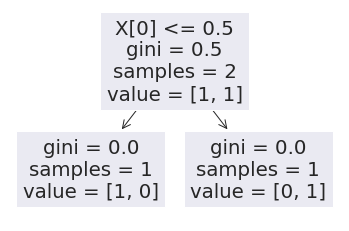

In [42]:
tree.plot_tree(clf)

or, more prettily:

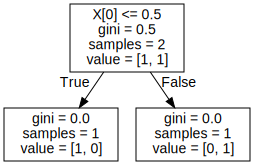

In [43]:
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

The gini label, also known as **Gini impurity**, is a measure of how often a sample passing through the node would be incorrectly labeled if it was randomly assigned a label based on the proportion of all labels passing through the node. So it is a measure of the progress of our tree.

Let's take a more complex example

In [44]:
from sklearn.datasets import make_classification as gen
X, y = gen(random_state=42)

Let's inspect our generated data:

In [45]:
print(X.shape)
print(y.shape)
y[:5] # a binary classification

(100, 20)
(100,)


array([0, 0, 1, 1, 0])

And now let's train our tree:

In [46]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, y)

How do we interpret this graph?

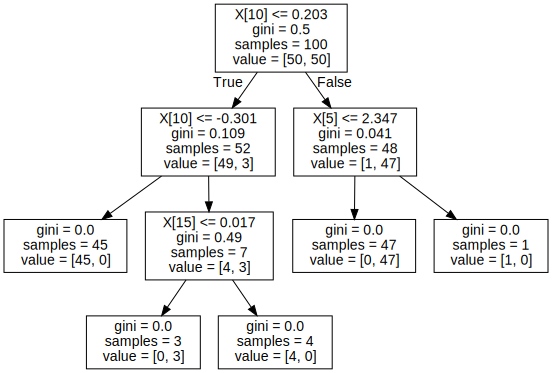

In [47]:
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

> Can we confirm the observations in the tree by manually inspecting X and y?

In [48]:
y[X[:,10] < .203]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0])

We can confirm the gini score of the top left node by hand...

In [49]:
scr = []
for j in range(1000):
  y_pred = [0 if random.random() > ( 3/52 ) else 1 for i in range(52)]
  y_true = [0 if random.random() > ( 3/52 ) else 1 for i in range(52)]
  scr.append(mean_squared_error(y_pred,y_true))
np.mean(scr)

0.1081346153846154

Let's take a look at this with our truffle dataset

> Vary the parameter `max_depth` what do you notice? Does the term _greedy_ mean anything to you? Do nodes higher in the tree change based on decisions lower in the tree?


In [50]:
clf = tree.DecisionTreeClassifier(max_depth=1)
clf.fit(X_truf, y_truf_class)

DecisionTreeClassifier(max_depth=1)

And now lets look at the graph:

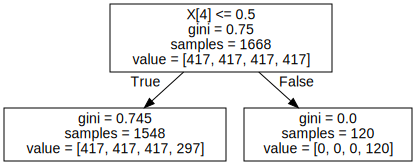

In [51]:
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

What is `X[4]`???

In [52]:
# It's those tasty sponge cake truffles!
enc.get_feature_names_out()[4]

'Base Cake_Sponge'

This is one great aspect of decision trees, their *interpretability*.

We will perform this analysis again, for now, let's proceed with simpler datasets while exploring the features of decision trees.

<a name='x.1.2.2'></a>

#### 6.1.2.1 Decision Boundaries

[back to top](#top)

Let's make some random blobs

In [53]:
from sklearn.datasets import make_blobs as gen
X, y = gen(random_state=42)

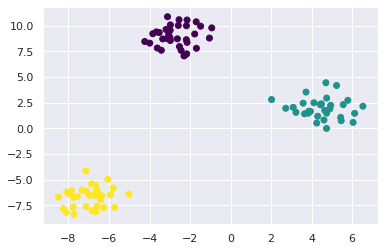

In [54]:
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis')

Let's call up our Classifier again, this time setting the `max_depth` to two

In [55]:
clf = tree.DecisionTreeClassifier(max_depth=2, random_state=42)
clf = clf.fit(X, y)

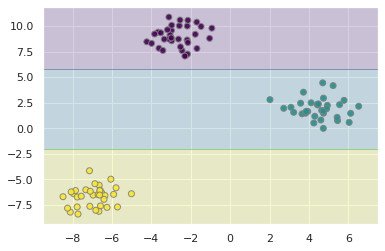

In [56]:
# Parameters
plot_step = 0.02

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                      np.arange(y_min, y_max, plot_step))
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
cs = plt.contourf(xx, yy, Z, cmap='viridis', alpha=0.2)

plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', edgecolor='grey', alpha=0.9)

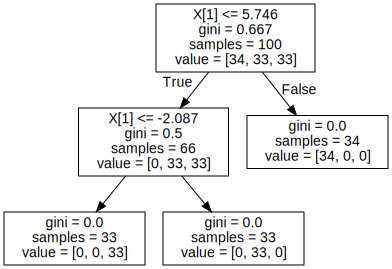

In [57]:
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
graph

We can see from the output of this graph, that the tree attempts to create the class boundaries as far from the cluster centers as possible. What happens when these clusters overlap?

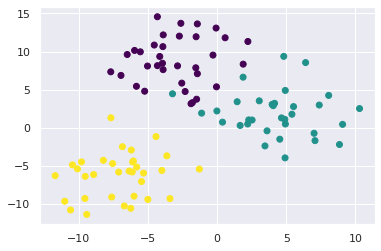

In [58]:
X, y = gen(random_state=42, cluster_std=3)
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis')

Let's go ahead and write our plot into a function

In [59]:
def plot_tree(X, clf):
  plot_step = 0.02
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                        np.arange(y_min, y_max, plot_step))
  plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  Z = Z.reshape(xx.shape)
  cs = plt.contourf(xx, yy, Z, cmap='viridis', alpha=0.2)

  plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', edgecolor='grey', alpha=0.9)
  return plt

We see that the boundaries mislabel some points

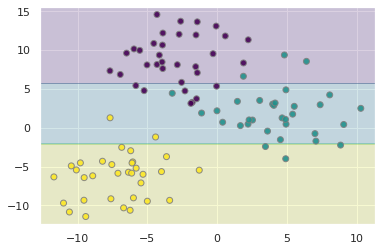

In [60]:
fig = plot_tree(X, clf)

<a name='x.1.3'></a>

### 6.1.3 Overfitting a Decision Tree

[back to top](#top)

Let's increase the max_depth

<module 'matplotlib.pyplot' from '/home/wbeckner/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/pyplot.py'>

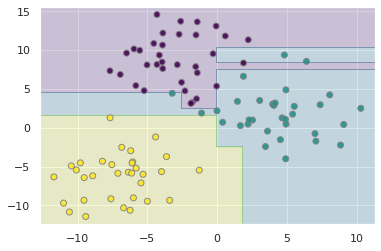

In [61]:
clf = tree.DecisionTreeClassifier(max_depth=5, random_state=42)
clf = clf.fit(X, y)
plot_tree(X, clf)

What we notice is that while the model accurately predicts the training data, we see some spurious labels, noteably the trailing purple bar that extends into the otherwise green region of the data. 

This is a well known fact about decision trees, that they tend to overfit their training data. In fact, this is a major motivation for why decision trees, a weak classifier, are conveniently packaged into ensembles.

We combine the idea of bootstrapping, with decision trees, to come up with an overall better classifier.

#### 🏋️ Exercise 1: Minimize Overfitting

Repeat 6.1.3 with different max_depth settings, also read the docstring and play with any other hyperparameters available to you. What settings do you feel minimize overfitting?

<module 'matplotlib.pyplot' from '/home/wbeckner/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/pyplot.py'>

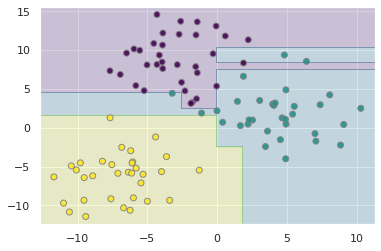

In [62]:
# Code Cell for 1

################################################################################
##### CHANGE THE HYPERPARAMETERS IN THE CALL TO DECISIONTREECLASSIFIER #########
################################################################################

clf = tree.DecisionTreeClassifier(random_state=42,
                                    max_depth=None,
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    min_weight_fraction_leaf=0.0,
                                    max_features=None,
                                    max_leaf_nodes=None,
                                    min_impurity_decrease=0.0,
                                    class_weight=None,
                                    ccp_alpha=0.0,)
clf = clf.fit(X, y)
plot_tree(X, clf)

<a name='x.2'></a>

## 6.2 Random Forests and Bagging

[back to top](#top)

<a name='x.2.1'></a>

### 6.2.1 What is Bagging?

[back to top](#top)

**_Bagging_**, or Bootstrap AGGregation is the process of creating subsets of your data and training separate models on them, and using the aggregate votes of the models to make a final prediction.

**_Bootstrapping_** is a topic in and of itself that we will just touch on here. Without going through the statistical rigor of proof, bootstrapping, or sampling from your observations with replacement, simulates having drawn additional data from the true population. We use this method to create many new datasets that are then used to *train separate learners* in parallel. This overall approach is called **_Bagging_**.

<p align=center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Ensemble_Bagging.svg/440px-Ensemble_Bagging.svg.png"></img>
</p>

A **_Random Forest_** is an instance of bagging where the separate learners are decision trees. 

<a name='x.2.2'></a>

### 6.2.2 Random Forests for Classification

[back to top](#top)

<module 'matplotlib.pyplot' from '/home/wbeckner/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/pyplot.py'>

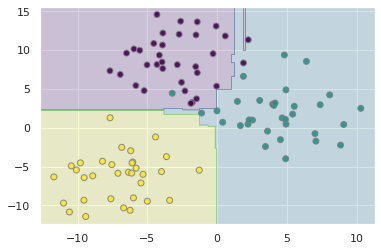

In [63]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=10, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
plot_tree(X, bag)

In the above, we have bootstrapped by providing each individual tree with 80% of the population data. In practice, Random Forests can achieve even better results by randomizing how the individual classifiers are constructed. In fact there are many unique methods of training individual trees and you can learn more about them [here](https://scikit-learn.org/stable/modules/ensemble.html#forest). This randomness is done automatically in sklearn's `RandomForestClassifier`

In [64]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, random_state=2)
clf = clf.fit(X, y)

<module 'matplotlib.pyplot' from '/home/wbeckner/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/pyplot.py'>

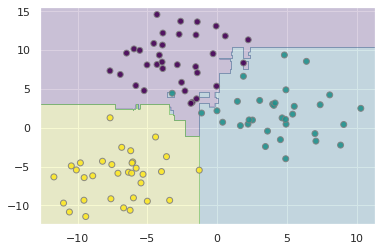

In [65]:
plot_tree(X, clf)

<a name='x.2.2.1'></a>

#### 6.2.2.1 Interpreting a Random Forest

[back to top](#top)

Let's revisit our truffle dataset again, this time with random forests

In [66]:
# fit the model
clf = RandomForestClassifier(n_estimators=10,
                             min_samples_leaf=6)
clf = clf.fit(X_truf, y_truf_class)

We get a fairly high accuracy when our `min_samples_leaf` is low and an accuracy that leaves room for improvement when `min_samples_leaf` is high. This indicates to us the model may be prown to overfitting if we are not careful:

In [67]:
accuracy_score(clf.predict(X_truf), y_truf_class)

0.6103117505995204

We can grab the original feature names with `get_feature_names_out()`:

In [68]:
feats = enc.get_feature_names_out()

The feature importances are stored in `clf.feature_importances_`. These are calculated from the **_Mean Decrease in Impurity_** or MDI also called the **_Gini Importance_**. It is the sum of the number of nodes across all trees that include the feature, weighted by the number of samples passing through the node. 

One downside of estimating feature importance in this way is that it doesn't play well with highly cardinal features _(features with many unique values such as mailing addresses, are highly cardinal features)_



In [69]:
len(feats)

118

In [71]:
# grab feature importances
imp = clf.feature_importances_

# their std
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

# create new dataframe
feat = pd.DataFrame([feats, imp, std]).T
feat.columns = ['feature', 'importance', 'std']
feat = feat.sort_values('importance', ascending=False)
feat = feat.reset_index(drop=True)
feat.dropna(inplace=True)
feat.head()

,feature,importance,std
0,Base Cake_Sponge,0.127523,0.083222
1,Base Cake_Pound,0.064996,0.055614
3,Secondary Flavor_Egg Nog,0.048034,0.063641
4,Base Cake_Chiffon,0.044027,0.039515
5,Base Cake_Butter,0.043494,0.048662


I'm going to use `plotly` to create this chart:

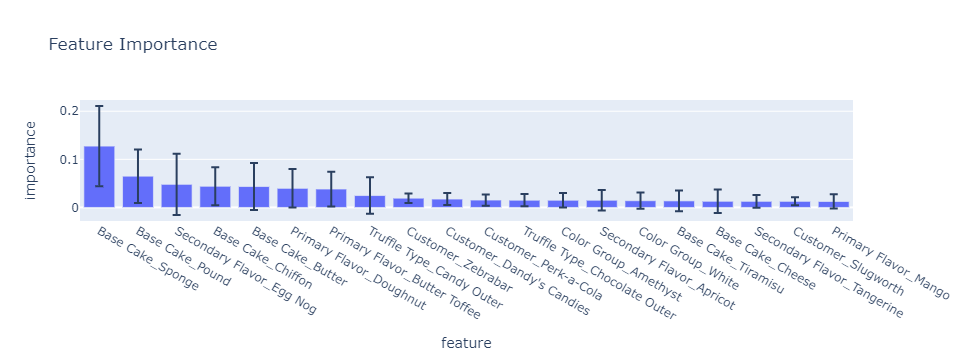

In [74]:
px.bar(feat[:20], x='feature', y='importance', error_y='std', title='Feature Importance')

#### 🙋‍♀️ Question 1: Feature Importance and Cardinality

How does feature importance change in the above plot when we change the minimum leaf size from 2 to 6?

#### 🙋‍ Question 2: Compare to Moods Median

We can then go and look at the different EBITDAs when selecting for each of these features. What do you notice as the primary difference between these results and those from [Session 2: Inferential Statistics Exercise 1, Part C](https://github.com/wesleybeckner/data_science_foundations/blob/fdf84755a7ed6ed54d3f036a7fc2d9dafa79afd9/notebooks/solutions/SOLN_S2_Inferential_Statistics.ipynb) when we ran Mood's Median test on this same data?

In [75]:
for feature in feat.iloc[:10,0]:
    group = feature.split('_')[0]
    sel = " ".join(feature.split('_')[1:])
    pos = margin.loc[(margin[group] == sel)]['EBITDA/KG'].median()
    neg = margin.loc[~(margin[group] == sel)]['EBITDA/KG'].median()
    print(group + ": " + sel)
    print("\twith:    {:.2f}".format(pos))
    print("\twithout: {:.2f}".format(neg))

Base Cake: Sponge
	with:    0.70
	without: 0.20
Base Cake: Pound
	with:    0.24
	without: 0.20
Secondary Flavor: Egg Nog
	with:    0.23
	without: 0.21
Base Cake: Chiffon
	with:    0.13
	without: 0.24
Base Cake: Butter
	with:    0.14
	without: 0.26
Primary Flavor: Doughnut
	with:    0.38
	without: 0.20
Primary Flavor: Butter Toffee
	with:    0.46
	without: 0.21
Truffle Type: Candy Outer
	with:    0.20
	without: 0.22
Customer: Zebrabar
	with:    0.24
	without: 0.21
Customer: Dandy's Candies
	with:    0.20
	without: 0.22


<a name='x.2.3'></a>

### 6.2.3 Random Forests for Regression

[back to top](#top)


In [76]:
from sklearn.ensemble import RandomForestRegressor

clf = RandomForestRegressor(n_estimators=10)

Because our labels on our blob data were numerical, we can apply and view the estimator in the same way:

<module 'matplotlib.pyplot' from '/home/wbeckner/anaconda3/envs/py39/lib/python3.9/site-packages/matplotlib/pyplot.py'>

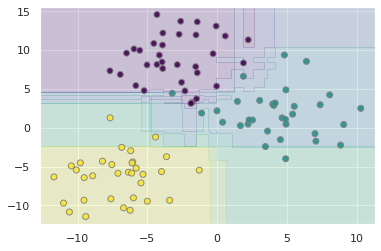

In [77]:
clf = clf.fit(X, y)
plot_tree(X, clf)

I want to revisit a dataset we brought up in Session 2 on feature engineering:

Text(0.5, 1.0, 'Frequency Domain')

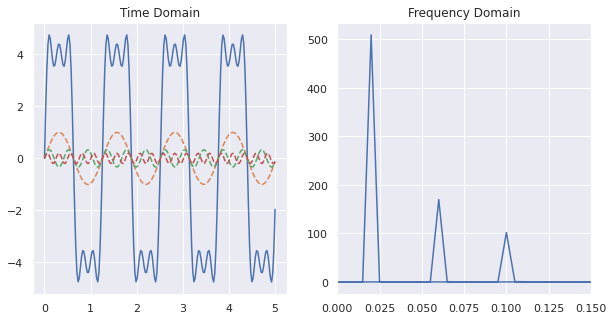

In [78]:
t = np.linspace(0,5,200)
w = 5
h = 4
s = 4 * h / np.pi * (np.sin(w*t) + np.sin(3*w*t)/3 + np.sin(5*w*t)/5)

F = np.fft.fft(s)
freq = np.fft.fftfreq(t.shape[-1])

fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].plot(t,s)
ax[0].plot(t,np.sin(w*t), ls='--')
ax[0].plot(t,np.sin(w*t*3)/3, ls='--')
ax[0].plot(t,np.sin(w*t*5)/5, ls='--')
ax[0].set_title('Time Domain')

# tells us about the amplitude of the component at the
# corresponding frequency
magnitude = np.sqrt(F.real**2 + F.imag**2)

ax[1].plot(freq, magnitude)
ax[1].set_xlim(0,.15)
ax[1].set_title('Frequency Domain')

Let's see if a random forest regression model can capture the wave behavior of the time-series data

In [79]:
clf = RandomForestRegressor(n_estimators=10)
clf.fit(t.reshape(-1,1),s)

RandomForestRegressor(n_estimators=10)

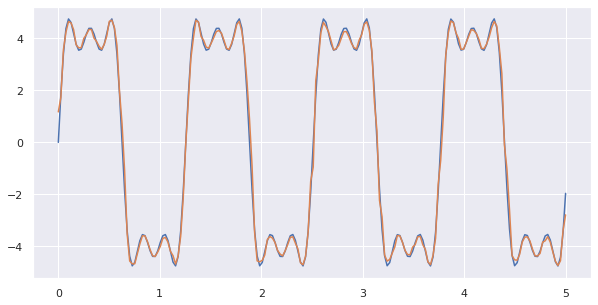

In [80]:
fig, ax = plt.subplots(1,1,figsize=(10,5))

ax.plot(t,s)
ax.plot(t,clf.predict(t.reshape(-1,1)))

Nice! without specifying any perdiodicity, the random forest does a good job of embedding this periodicity in the final output.

### 🏋️ Exercise 2: Practice with Random Forests

With the wine dataset:

* predict: density
* create a learning curve of train/test score vs model complexity for your random forest model(s)

I have provided the _cleaned_ dataset as well as starter code for trainin the model and making parity plots

Do not change the following 3 cells:

In [81]:
wine = pd.read_csv("https://raw.githubusercontent.com/wesleybeckner/"\
      "ds_for_engineers/main/data/wine_quality/winequalityN.csv")
# infer str cols
str_cols = list(wine.select_dtypes(include='object').columns)

#set target col
target = 'density'

enc = OneHotEncoder()
imp = SimpleImputer()

enc.fit_transform(wine[str_cols])
X_cat = enc.transform(wine[str_cols]).toarray()
X = wine.copy()
[X.pop(i) for i in str_cols]
y = X.pop(target)
X = imp.fit_transform(X)
X = np.hstack([X_cat, X])

cols = [i.split("_")[1] for i in enc.get_feature_names_out()]
cols += list(wine.columns)
cols.remove(target)
[cols.remove(i) for i in str_cols]

scaler = StandardScaler()
X[:,2:] = scaler.fit_transform(X[:,2:])

wine = pd.DataFrame(X, columns=cols)
wine['density'] = y

In [82]:
model = RandomForestRegressor(n_estimators=100,
                            criterion='squared_error',
                            max_depth=None,
                            min_samples_split=2,
                            min_samples_leaf=1,
                            min_weight_fraction_leaf=0.0,
                            max_features='auto',
                            max_leaf_nodes=None,
                            min_impurity_decrease=0.0,
                            bootstrap=True,
                            oob_score=False,
                            n_jobs=None,
                            random_state=None,
                            verbose=0,
                            warm_start=False,
                            ccp_alpha=0.0,
                            max_samples=None,)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Text(0.5, 1.0, 'Test, R2: 0.973')

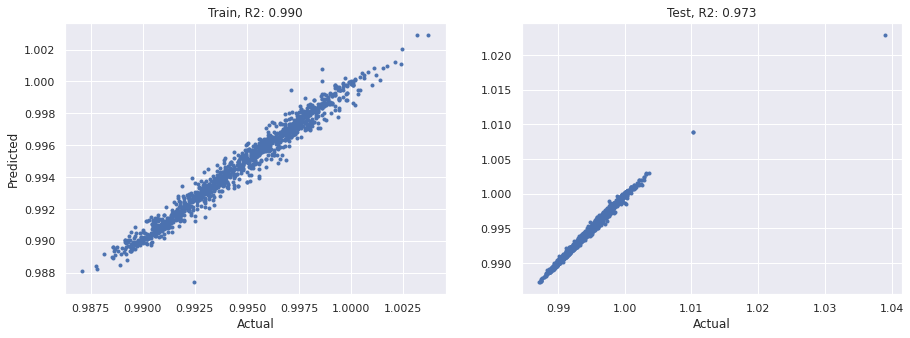

In [83]:
fig, (ax, ax_) = plt.subplots(1,2,figsize=(15,5))
ax.plot(y_test, model.predict(X_test), ls='', marker='.')
ax_.plot(y_train, model.predict(X_train), ls='', marker='.')
ax.set_title("Train, R2: {:.3f}".format(r2_score(y_train, model.predict(X_train))))
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
ax_.set_xlabel('Actual')
ax_.set_title("Test, R2: {:.3f}".format(r2_score(y_test, model.predict(X_test))))

Compare these results with our [linear model](https://github.com/wesleybeckner/data_science_foundations/blob/fdf84755a7ed6ed54d3f036a7fc2d9dafa79afd9/notebooks/solutions/SOLN_E3_Feature_Engineering.ipynb) from Lab 3.

Recall that we can quickly grab the names of the paramters in our sklearn model:

In [84]:
RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [85]:
# Cell for Exercise 2